# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [8]:
import pandas as pd
import numpy as np

In [9]:
# This can be used to load the dataset
data = pd.read_csv("adult_all.csv", header=None, na_values='?')
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
data.dtypes

0      int64
1     object
2      int64
3     object
4      int64
5     object
6     object
7     object
8     object
9     object
10     int64
11     int64
12     int64
13    object
14    object
dtype: object

### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

#### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers.

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns; sns.set_theme()

# Define your preprocessing steps here

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

train = data
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train.select_dtypes(include=['object']).drop([14], axis=1).columns

transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)]

steps = transformers

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(steps)

# show the correlation between different features including target variable
def visualize(data, ct):
    corr = data.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    pass

# Apply your model to feature array X and labels y
def apply_model(model, X, y):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    
    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline):
    pipeline.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipeline.score(X, y))
    return pipeline.score(X, y)

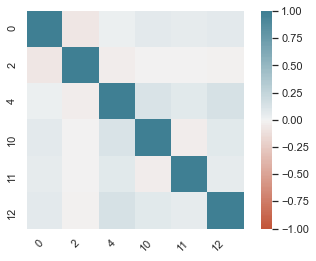

In [12]:
visualize(data,ct)

In [13]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

train = data

X = train.drop(14, axis=1)
y = train[14]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier()
    ]
for classifier in classifiers:
    apply_model(classifier, X_test, y_test)


KNeighborsClassifier(n_neighbors=3)
model score: 0.832
DecisionTreeClassifier()
model score: 0.813
RandomForestClassifier()
model score: 0.857
AdaBoostClassifier()
model score: 0.864


### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [16]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y: np.ndarray, fraction: float) -> np.ndarray:
    copy = data.copy()
    copy['label'] = copy[14].eq('>50K').astype(int)
    length = (len(copy['label']))
    rand_flip = np.int(fraction*length)
    # Flip fraction*len(data) of the labels in copy
    idx = np.random.choice(length,rand_flip,replace=False)
    #print(len(idx))
    #print(len(copy['label'][copy['label'] == 0]))
    #print(len(copy['label'][copy['label'] == 1]))
    copy['label'][idx] = np.abs(1-copy['label'][idx])
    #print(len(copy['label'][copy['label'] == 0]))
    #print(len(copy['label'][copy['label'] == 1]))
    return copy

In [17]:
data['label'] = data[14].eq('>50K').astype(int)
#label = data['label']
#print(data['label'])
print(len(data['label'][data['label'] == 0]))
print(len(data['label'][data['label'] == 1]))
#print(len(data['label']))
y = data
fraction = 0.1
data_new = pertubate(y, fraction)
#print(data['label'])
#print(len(data['label']))
print(len(data_new['label'][data_new['label'] == 0]))
print(len(data_new['label'][data_new['label'] == 1]))

37155
11687
34571
14271


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [18]:
# Code
# code takes long time due to 4 models x 5 iterations each x 6 perturbation fraction values

# Apply your model to feature array X and labels y
def apply_model(model, X, y):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    
    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline, model)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline, model):
    pipeline.fit(X_train, y_train)   
    print(model)
    print("model score: %.3f" % pipeline.score(X, y))
    return pipeline.score(X, y)



y = data
i = 0
frac = np.arange(0,0.6,0.1)
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier()
    ]
score = np.zeros((len(frac), len(classifiers), 5))
while i < len(frac):
    k = 0
    while k < 5:
        fraction = frac[i]
        data_new = pertubate(y, fraction)
        train = data_new
        X = train.drop(14, axis=1)
        y = train[14]
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        j = 0
        while j < len(classifiers):
            score[i,j,k] = apply_model(classifiers[j], X_test, y_test)
            j = j+1
        k = k+1
    i = i+1

print(score)

<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.822
DecisionTreeClassifier()
model score: 0.812
RandomForestClassifier()
model score: 0.851
AdaBoostClassifier()
model score: 0.860


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.814
RandomForestClassifier()
model score: 0.855
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.809
RandomForestClassifier()
model score: 0.854
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.825
DecisionTreeClassifier()
model score: 0.813
RandomForestClassifier()
model score: 0.853
AdaBoostClassifier()
model score: 0.862


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.827
DecisionTreeClassifier()
model score: 0.812
RandomForestClassifier()
model score: 0.853
AdaBoostClassifier()
model score: 0.861


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.827
DecisionTreeClassifier()
model score: 0.820
RandomForestClassifier()
model score: 0.855
AdaBoostClassifier()
model score: 0.857


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.824
DecisionTreeClassifier()
model score: 0.820
RandomForestClassifier()
model score: 0.849
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.817
RandomForestClassifier()
model score: 0.855
AdaBoostClassifier()
model score: 0.861


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.827
DecisionTreeClassifier()
model score: 0.811
RandomForestClassifier()
model score: 0.853
AdaBoostClassifier()
model score: 0.864


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.818
RandomForestClassifier()
model score: 0.855
AdaBoostClassifier()
model score: 0.860


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.822
DecisionTreeClassifier()
model score: 0.813
RandomForestClassifier()
model score: 0.852
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.814
RandomForestClassifier()
model score: 0.853
AdaBoostClassifier()
model score: 0.863


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.822
DecisionTreeClassifier()
model score: 0.820
RandomForestClassifier()
model score: 0.854
AdaBoostClassifier()
model score: 0.864


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.827
DecisionTreeClassifier()
model score: 0.818
RandomForestClassifier()
model score: 0.854
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.816
RandomForestClassifier()
model score: 0.856
AdaBoostClassifier()
model score: 0.864


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.819
DecisionTreeClassifier()
model score: 0.810
RandomForestClassifier()
model score: 0.848
AdaBoostClassifier()
model score: 0.855


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.824
DecisionTreeClassifier()
model score: 0.813
RandomForestClassifier()
model score: 0.853
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.823
DecisionTreeClassifier()
model score: 0.816
RandomForestClassifier()
model score: 0.854
AdaBoostClassifier()
model score: 0.856


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.822
DecisionTreeClassifier()
model score: 0.813
RandomForestClassifier()
model score: 0.854
AdaBoostClassifier()
model score: 0.860


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.819
RandomForestClassifier()
model score: 0.855
AdaBoostClassifier()
model score: 0.861


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.825
DecisionTreeClassifier()
model score: 0.817
RandomForestClassifier()
model score: 0.853
AdaBoostClassifier()
model score: 0.857


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.827
DecisionTreeClassifier()
model score: 0.816
RandomForestClassifier()
model score: 0.857
AdaBoostClassifier()
model score: 0.861


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.824
DecisionTreeClassifier()
model score: 0.817
RandomForestClassifier()
model score: 0.855
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.827
DecisionTreeClassifier()
model score: 0.808
RandomForestClassifier()
model score: 0.846
AdaBoostClassifier()
model score: 0.858


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.826
DecisionTreeClassifier()
model score: 0.815
RandomForestClassifier()
model score: 0.852
AdaBoostClassifier()
model score: 0.857


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.830
DecisionTreeClassifier()
model score: 0.823
RandomForestClassifier()
model score: 0.860
AdaBoostClassifier()
model score: 0.864


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.821
DecisionTreeClassifier()
model score: 0.814
RandomForestClassifier()
model score: 0.848
AdaBoostClassifier()
model score: 0.859


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.829
DecisionTreeClassifier()
model score: 0.814
RandomForestClassifier()
model score: 0.855
AdaBoostClassifier()
model score: 0.863


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.820
DecisionTreeClassifier()
model score: 0.814
RandomForestClassifier()
model score: 0.854
AdaBoostClassifier()
model score: 0.862


<ipython-input-16-4562ffaf9d6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy['label'][idx] = np.abs(1-copy['label'][idx])


KNeighborsClassifier(n_neighbors=3)
model score: 0.822
DecisionTreeClassifier()
model score: 0.810
RandomForestClassifier()
model score: 0.851
AdaBoostClassifier()
model score: 0.862
[[[0.82229501 0.82628724 0.82587778 0.82516122 0.82700379]
  [0.81154673 0.81410585 0.80888525 0.81287747 0.81226328]
  [0.85095711 0.85505169 0.85382332 0.85320913 0.85269731]
  [0.86016993 0.85935101 0.85935101 0.86191012 0.86098884]]

 [[0.82669669 0.82352339 0.82577541 0.82710615 0.82557068]
  [0.82004299 0.82035009 0.81697205 0.81144436 0.81840516]
  [0.85505169 0.84860272 0.85484696 0.85269731 0.85484696]
  [0.85730372 0.85904391 0.86109121 0.86426451 0.85976047]]

 [[0.82239738 0.8263896  0.82188556 0.82700379 0.8263896 ]
  [0.81287747 0.81390112 0.81994063 0.81809807 0.81615314]
  [0.85187839 0.8530044  0.85351622 0.85413041 0.8564848 ]
  [0.85883919 0.86283141 0.86385505 0.85883919 0.86416215]]

 [[0.81912171 0.82403521 0.82342103 0.82168083 0.82618487]
  [0.8099089  0.81338929 0.81574368 0.813389

<function matplotlib.pyplot.show(close=None, block=None)>

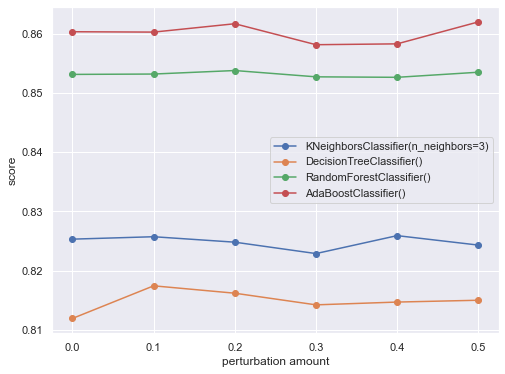

In [19]:
import matplotlib.pyplot as plt

score_mean = np.mean(score, axis = 2)
score_std = np.std(score, axis = 2)

fig = plt.figure(figsize = (8,6))
i = 0
while i < len(score_mean[0,:]):
    plt.plot(frac, score_mean[:,i], marker = 'o', label = str(classifiers[i]))
    
    i = i+1


plt.xlabel('perturbation amount')
plt.ylabel('score')
plt.legend()
plt.show

Observations + explanations: max. 400 words

#### Discussion
Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
max. 400 words

Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.